# HQ-SAM inference
> Inference with high quality SAM

In [1]:
#| default_exp HQ_SAM.inference

In [2]:
#| hide
%load_ext autoreload
%autoreload 2


In [31]:
#| export
import sys
from pathlib import Path
from PIL import Image
from typing import List


In [0]:
#| export
CV_TOOLS = Path(r'/home/ai_sintercra/homes/hasan/projects/git_data/cv_tools')
sys.path.append(str(CV_TOOLS))


In [0]:
#| export
custom_lib_path = Path(r'/home/ai_warstein/homes/goni/custom_libs')
sys.path.append(str(custom_lib_path))


In [20]:
#| export
from cv_tools.imports import *
from cv_tools.core import *
from cv_tools.dataset_check import *
from dotenv import load_dotenv
import matplotlib.pyplot as plt


In [0]:
#| export
#load_dotenv(dotenv_path=f'/home/ai_sintercra/homes/hasan/projects/git_data/labeling_test/labeling_test/.env')

In [5]:
import torch
from transformers import SamHQModel, SamHQProcessor

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = SamHQModel.from_pretrained(
    "syscv-community/sam_hq_vit_b",
    cache_dir=None # use cache dir in case of HPC
    ).to(device)

In [8]:
processor = SamHQProcessor.from_pretrained(
    "syscv-community/sam-hq-vit-base")

In [9]:
from datasets import load_dataset

ds = load_dataset("hasangoni/Electron_microscopy_dataset")

In [10]:
image = ds['train']['image'][0]
mask = ds['train']['label'][0]

In [14]:
inputs = processor(
    image, return_tensors="pt").to(device)
image_embeddings, intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])
image_embeddings.shape,len(intermediate_embeddings)

c:\Users\goni\AppData\Local\miniforge3\Lib\site-packages\transformers\image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


(torch.Size([1, 256, 64, 64]), 4)

In [15]:
#| export
def show_points(
    coords, 
    labels, 
    ax, 
    marker_size=375):
    'Show points on a image'
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [16]:
#| export
def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

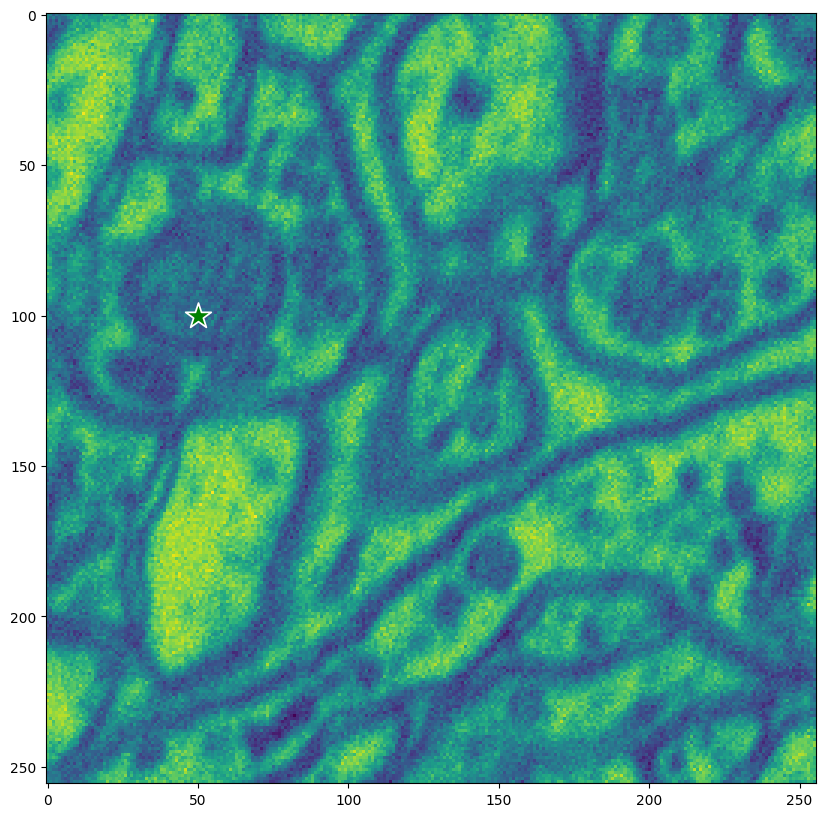

In [25]:
input_points = [[[50, 100]]]
show_points_on_image(image, input_points[0])

In [26]:
inputs = processor(image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not needed
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.update({"intermediate_embeddings": intermediate_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

c:\Users\goni\AppData\Local\miniforge3\Lib\site-packages\transformers\image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [27]:
#| export
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [28]:
#| export
def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

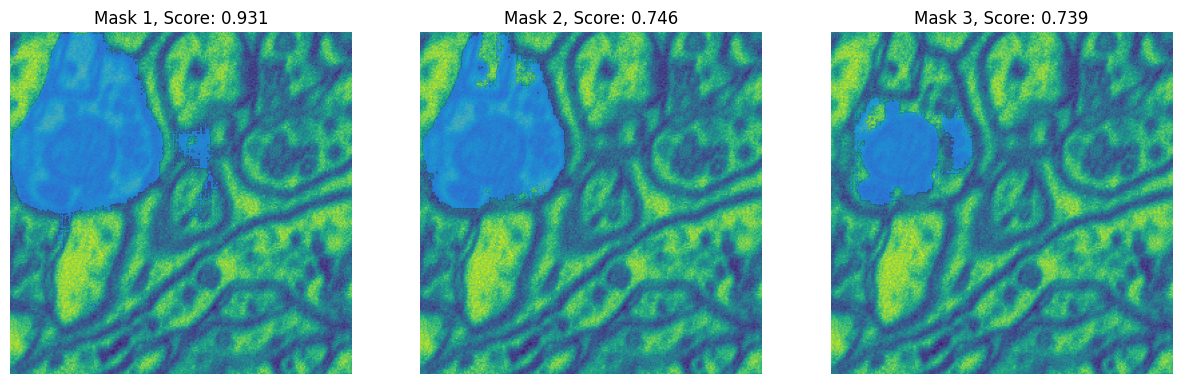

In [29]:
show_masks_on_image(image, masks[0], scores)

- lets create some function to work seamlessly with the dataset

In [34]:
def get_embeddings(
    image:Image.Image, # PIL image
    processor:SamHQProcessor, # SAMHQ processor
    model:SamHQModel, # SAMHQ model
    device:torch.device # torch device
    )->tuple[torch.Tensor,List[torch.Tensor]]:
    'Get image embeddings and intermediate embeddings'

    inputs = processor(
        image, 
        return_tensors="pt").to(device)
    embeddings,intermediate_embeddings = model.get_image_embeddings(inputs["pixel_values"])
    return embeddings,intermediate_embeddings



In [35]:
emb, int_emb = get_embeddings(
    image, 
    processor, 
    model, 
    device)


c:\Users\goni\AppData\Local\miniforge3\Lib\site-packages\transformers\image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [ ]:
def get_masks_from_points(
    image:Image.Image,
    processor:SamHQProcessor,
    model:SamHQModel,
    device:torch.device,
    points:List[List[int]],
    )->tuple[torch.Tensor,List[torch.Tensor]]:
    'Get masks from points'

In [0]:
#| export
CURRETNT_NB='/home/ai_sintercra/homes/hasan/projects/git_data/labeling_test/nbs'

In [0]:
#| hide
import nbdev; nbdev.nbdev_export('09_HQ_SAM.inference.ipynb')